In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        
        self.conv = nn.Conv2d(
            in_channels=self.input_channels + self.hidden_channels,
            out_channels=4 * self.hidden_channels,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=True
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_channels, dim=1)
        
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

class FramePredictor(nn.Module):
    def __init__(self, input_channels=1, hidden_channels=64):
        super(FramePredictor, self).__init__()
        
        # Proper weight initialization function
        def init_weights(m):
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
        # Encoder with BatchNorm
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # ConvLSTM
        self.convlstm = ConvLSTMCell(64, hidden_channels, kernel_size=3)
        
        # Decoder with BatchNorm
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(hidden_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.deconv3 = nn.ConvTranspose2d(16, input_channels, kernel_size=3, padding=1)
        
        # Apply weight initialization
        self.apply(init_weights)
        
    def forward(self, x):
        batch_size, _, seq_len, height, width = x.size()
        
        h = torch.zeros(batch_size, self.convlstm.hidden_channels, height, width).to(x.device)
        c = torch.zeros(batch_size, self.convlstm.hidden_channels, height, width).to(x.device)
        
        for t in range(seq_len):
            current = x[:, :, t, :, :]
            
            # Encoder
            enc1 = self.conv1(current)
            enc2 = self.conv2(enc1)
            enc3 = self.conv3(enc2)
            
            # ConvLSTM
            h, c = self.convlstm(enc3, (h, c))
        
        # Decoder
        dec1 = self.deconv1(h)
        dec2 = self.deconv2(dec1)
        # Remove sigmoid, use tanh instead for better gradient flow
        output = torch.tanh(self.deconv3(dec2))
        # Scale output to [0, 1] range
        output = (output + 1) / 2
        
        return output

def collate(batch):
    # Add debugging prints
    batch = torch.tensor(batch).unsqueeze(1)
    print("Raw input range:", batch.min().item(), batch.max().item())
    batch = batch / 255.0
    print("After scaling:", batch.min().item(), batch.max().item())
    batch = batch.to(device)
    rand = np.random.randint(10,20)
    return batch[:,:,rand-10:rand], batch[:,:,rand]

# Combined loss function
class CombinedLoss(nn.Module):
    def __init__(self, mse_weight=1.0, l1_weight=0.1):
        super().__init__()
        self.mse_weight = mse_weight
        self.l1_weight = l1_weight
        self.mse = nn.MSELoss()
        self.l1 = nn.L1Loss()
    
    def forward(self, pred, target):
        return self.mse_weight * self.mse(pred, target) + self.l1_weight * self.l1(pred, target)

In [ ]:
# Load Data as Numpy Array
MovingMNIST = np.load('C:/Users/arnab/Desktop/Github/MNIST/mnist_test_seq.npy').transpose(1, 0, 2, 3)

# Shuffle Data
np.random.shuffle(MovingMNIST)

# Train, Test, Validation splits
train_data = MovingMNIST[:8000]         
val_data = MovingMNIST[8000:9000]       
test_data = MovingMNIST[9000:10000]     

def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20)                     
    return batch[:,:,rand-10:rand], batch[:,:,rand]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

In [19]:
def plot_losses(train_losses, val_losses):
    """Plot training and validation losses over epochs."""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses Over Time')
    plt.legend()
    plt.grid(True)
    
    # Add minimum loss values to the plot
    min_train_loss = min(train_losses)
    min_val_loss = min(val_losses)
    min_train_epoch = train_losses.index(min_train_loss)
    min_val_epoch = val_losses.index(min_val_loss)
    
    plt.annotate(f'Min Train Loss: {min_train_loss:.4f}',
                 xy=(min_train_epoch, min_train_loss),
                 xytext=(10, 10),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.annotate(f'Min Val Loss: {min_val_loss:.4f}',
                 xy=(min_val_epoch, min_val_loss),
                 xytext=(10, 10),
                 textcoords='offset points',
                 ha='right',
                 va='top',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    
    plt.tight_layout()
    plt.show()

In [24]:
def train_model(model, train_loader, val_loader, num_epochs=50):
    criterion = CombinedLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    max_grad_norm = 1.0
    best_val_loss = float('inf')
    best_model = None
    
    # Lists to store losses for plotting
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}/{num_epochs}')
        
        for inputs, targets in train_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Validation
        model.eval()
        val_loss = 0
        val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}/{num_epochs}')
        
        with torch.no_grad():
            for inputs, targets in val_bar:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Store losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}:')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Average Validation Loss: {avg_val_loss:.4f}')
        print('------------------------')
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
    
    # Plot losses
    plot_losses(train_losses, val_losses)
    
    # Load best model
    model.load_state_dict(best_model)
    return model

Validation Epoch 1/50: 100%|██████████| 63/63 [00:16<00:00,  3.91it/s, loss=0.0222]


Epoch 1:
Average Training Loss: 0.0326
Average Validation Loss: 0.0207
------------------------


Validation Epoch 2/50: 100%|██████████| 63/63 [00:16<00:00,  3.89it/s, loss=0.0167]


Epoch 2:
Average Training Loss: 0.0202
Average Validation Loss: 0.0193
------------------------


Validation Epoch 3/50: 100%|██████████| 63/63 [00:16<00:00,  3.86it/s, loss=0.0182]


Epoch 3:
Average Training Loss: 0.0192
Average Validation Loss: 0.0189
------------------------


Validation Epoch 4/50: 100%|██████████| 63/63 [00:17<00:00,  3.61it/s, loss=0.0164]


Epoch 4:
Average Training Loss: 0.0184
Average Validation Loss: 0.0176
------------------------


Validation Epoch 5/50: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s, loss=0.0160]


Epoch 5:
Average Training Loss: 0.0178
Average Validation Loss: 0.0170
------------------------


Validation Epoch 6/50: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s, loss=0.0188]


Epoch 6:
Average Training Loss: 0.0171
Average Validation Loss: 0.0165
------------------------


Validation Epoch 7/50: 100%|██████████| 63/63 [00:17<00:00,  3.64it/s, loss=0.0217]


Epoch 7:
Average Training Loss: 0.0165
Average Validation Loss: 0.0160
------------------------


Validation Epoch 8/50: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s, loss=0.0156]


Epoch 8:
Average Training Loss: 0.0163
Average Validation Loss: 0.0152
------------------------


Validation Epoch 9/50: 100%|██████████| 63/63 [00:17<00:00,  3.64it/s, loss=0.0173]


Epoch 9:
Average Training Loss: 0.0158
Average Validation Loss: 0.0156
------------------------


Validation Epoch 10/50: 100%|██████████| 63/63 [00:17<00:00,  3.63it/s, loss=0.0122]


Epoch 10:
Average Training Loss: 0.0155
Average Validation Loss: 0.0151
------------------------


Validation Epoch 11/50: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s, loss=0.0139]


Epoch 11:
Average Training Loss: 0.0154
Average Validation Loss: 0.0147
------------------------


Validation Epoch 12/50: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s, loss=0.0165]


Epoch 12:
Average Training Loss: 0.0150
Average Validation Loss: 0.0149
------------------------


Validation Epoch 13/50: 100%|██████████| 63/63 [00:17<00:00,  3.63it/s, loss=0.0150]


Epoch 13:
Average Training Loss: 0.0148
Average Validation Loss: 0.0144
------------------------


Validation Epoch 14/50: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s, loss=0.0128]


Epoch 14:
Average Training Loss: 0.0147
Average Validation Loss: 0.0144
------------------------


Validation Epoch 15/50: 100%|██████████| 63/63 [00:16<00:00,  3.74it/s, loss=0.0113]


Epoch 15:
Average Training Loss: 0.0144
Average Validation Loss: 0.0138
------------------------


Validation Epoch 16/50: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s, loss=0.0126]


Epoch 16:
Average Training Loss: 0.0143
Average Validation Loss: 0.0137
------------------------


Validation Epoch 17/50: 100%|██████████| 63/63 [00:17<00:00,  3.70it/s, loss=0.0142]


Epoch 17:
Average Training Loss: 0.0142
Average Validation Loss: 0.0139
------------------------


Validation Epoch 18/50: 100%|██████████| 63/63 [00:17<00:00,  3.69it/s, loss=0.0132]


Epoch 18:
Average Training Loss: 0.0141
Average Validation Loss: 0.0136
------------------------


Validation Epoch 19/50: 100%|██████████| 63/63 [00:17<00:00,  3.67it/s, loss=0.0103]


Epoch 19:
Average Training Loss: 0.0139
Average Validation Loss: 0.0132
------------------------


Validation Epoch 20/50: 100%|██████████| 63/63 [00:17<00:00,  3.68it/s, loss=0.0177]


Epoch 20:
Average Training Loss: 0.0139
Average Validation Loss: 0.0134
------------------------


Validation Epoch 21/50: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s, loss=0.0171]


Epoch 21:
Average Training Loss: 0.0136
Average Validation Loss: 0.0138
------------------------


Validation Epoch 22/50: 100%|██████████| 63/63 [00:17<00:00,  3.58it/s, loss=0.0154]


Epoch 22:
Average Training Loss: 0.0136
Average Validation Loss: 0.0135
------------------------


Validation Epoch 23/50: 100%|██████████| 63/63 [00:17<00:00,  3.65it/s, loss=0.0135]


Epoch 23:
Average Training Loss: 0.0134
Average Validation Loss: 0.0135
------------------------


Validation Epoch 24/50: 100%|██████████| 63/63 [00:16<00:00,  3.87it/s, loss=0.0075]


Epoch 24:
Average Training Loss: 0.0134
Average Validation Loss: 0.0131
------------------------


Validation Epoch 25/50: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s, loss=0.0118]


Epoch 25:
Average Training Loss: 0.0134
Average Validation Loss: 0.0130
------------------------


Validation Epoch 26/50: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s, loss=0.0100]


Epoch 26:
Average Training Loss: 0.0132
Average Validation Loss: 0.0132
------------------------


Validation Epoch 27/50: 100%|██████████| 63/63 [00:16<00:00,  3.84it/s, loss=0.0143]


Epoch 27:
Average Training Loss: 0.0131
Average Validation Loss: 0.0126
------------------------


Validation Epoch 28/50: 100%|██████████| 63/63 [00:16<00:00,  3.88it/s, loss=0.0120]


Epoch 28:
Average Training Loss: 0.0130
Average Validation Loss: 0.0128
------------------------


Validation Epoch 29/50: 100%|██████████| 63/63 [00:19<00:00,  3.30it/s, loss=0.0134]


Epoch 29:
Average Training Loss: 0.0130
Average Validation Loss: 0.0128
------------------------


Validation Epoch 30/50: 100%|██████████| 63/63 [00:19<00:00,  3.31it/s, loss=0.0175]


Epoch 30:
Average Training Loss: 0.0129
Average Validation Loss: 0.0129
------------------------


Validation Epoch 31/50: 100%|██████████| 63/63 [00:17<00:00,  3.52it/s, loss=0.0128]


Epoch 31:
Average Training Loss: 0.0128
Average Validation Loss: 0.0127
------------------------


Validation Epoch 32/50: 100%|██████████| 63/63 [00:18<00:00,  3.46it/s, loss=0.0099]


Epoch 32:
Average Training Loss: 0.0128
Average Validation Loss: 0.0124
------------------------


Validation Epoch 33/50: 100%|██████████| 63/63 [00:18<00:00,  3.37it/s, loss=0.0114]


Epoch 33:
Average Training Loss: 0.0128
Average Validation Loss: 0.0126
------------------------


Validation Epoch 34/50: 100%|██████████| 63/63 [00:17<00:00,  3.57it/s, loss=0.0166]


Epoch 34:
Average Training Loss: 0.0128
Average Validation Loss: 0.0126
------------------------


Validation Epoch 35/50: 100%|██████████| 63/63 [00:15<00:00,  4.09it/s, loss=0.0119]


Epoch 35:
Average Training Loss: 0.0127
Average Validation Loss: 0.0128
------------------------


Validation Epoch 36/50: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s, loss=0.0113]


Epoch 36:
Average Training Loss: 0.0125
Average Validation Loss: 0.0123
------------------------


Validation Epoch 37/50: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s, loss=0.0095]


Epoch 37:
Average Training Loss: 0.0126
Average Validation Loss: 0.0124
------------------------


Validation Epoch 38/50: 100%|██████████| 63/63 [00:15<00:00,  4.11it/s, loss=0.0135]


Epoch 38:
Average Training Loss: 0.0125
Average Validation Loss: 0.0124
------------------------


Validation Epoch 39/50: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s, loss=0.0103]


Epoch 39:
Average Training Loss: 0.0125
Average Validation Loss: 0.0120
------------------------


Validation Epoch 40/50: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s, loss=0.0133]


Epoch 40:
Average Training Loss: 0.0124
Average Validation Loss: 0.0125
------------------------


Validation Epoch 41/50: 100%|██████████| 63/63 [00:15<00:00,  4.10it/s, loss=0.0128]


Epoch 41:
Average Training Loss: 0.0125
Average Validation Loss: 0.0120
------------------------


Validation Epoch 42/50: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s, loss=0.0149]


Epoch 42:
Average Training Loss: 0.0124
Average Validation Loss: 0.0122
------------------------


Validation Epoch 43/50: 100%|██████████| 63/63 [00:15<00:00,  4.12it/s, loss=0.0120]


Epoch 43:
Average Training Loss: 0.0123
Average Validation Loss: 0.0119
------------------------


Validation Epoch 44/50: 100%|██████████| 63/63 [00:15<00:00,  4.09it/s, loss=0.0137]


Epoch 44:
Average Training Loss: 0.0122
Average Validation Loss: 0.0123
------------------------


Validation Epoch 45/50: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s, loss=0.0088]


Epoch 45:
Average Training Loss: 0.0123
Average Validation Loss: 0.0122
------------------------


Validation Epoch 46/50: 100%|██████████| 63/63 [00:15<00:00,  4.13it/s, loss=0.0094]


Epoch 46:
Average Training Loss: 0.0122
Average Validation Loss: 0.0116
------------------------


Validation Epoch 47/50: 100%|██████████| 63/63 [00:15<00:00,  4.08it/s, loss=0.0120]


Epoch 47:
Average Training Loss: 0.0122
Average Validation Loss: 0.0119
------------------------


Validation Epoch 48/50: 100%|██████████| 63/63 [00:15<00:00,  4.09it/s, loss=0.0106]


Epoch 48:
Average Training Loss: 0.0121
Average Validation Loss: 0.0122
------------------------


Validation Epoch 49/50: 100%|██████████| 63/63 [00:15<00:00,  3.95it/s, loss=0.0107]


Epoch 49:
Average Training Loss: 0.0120
Average Validation Loss: 0.0119
------------------------


Validation Epoch 50/50: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s, loss=0.0115]


Epoch 50:
Average Training Loss: 0.0121
Average Validation Loss: 0.0119
------------------------


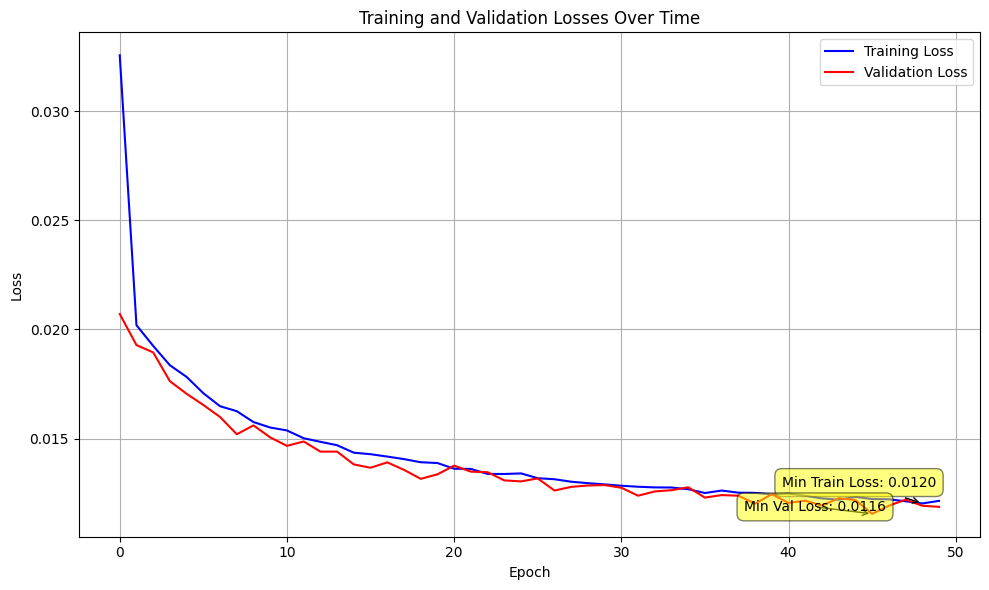

In [25]:
# Initialize and train the model
model = FramePredictor().to(device)
model = train_model(model, train_loader, val_loader)



Visualization sample 1:
Input range: 0.0000 to 1.0000
Target range: 0.0000 to 1.0000
Prediction range: 0.0000 to 0.9860

Visualization sample 2:
Input range: 0.0000 to 1.0000
Target range: 0.0000 to 1.0000
Prediction range: 0.0000 to 0.9619

Visualization sample 3:
Input range: 0.0000 to 1.0000
Target range: 0.0000 to 1.0000
Prediction range: 0.0000 to 0.9774

Visualization sample 4:
Input range: 0.0000 to 1.0000
Target range: 0.0000 to 1.0000
Prediction range: 0.0000 to 0.9955

Visualization sample 5:
Input range: 0.0000 to 1.0000
Target range: 0.0000 to 1.0000
Prediction range: 0.0000 to 0.9899


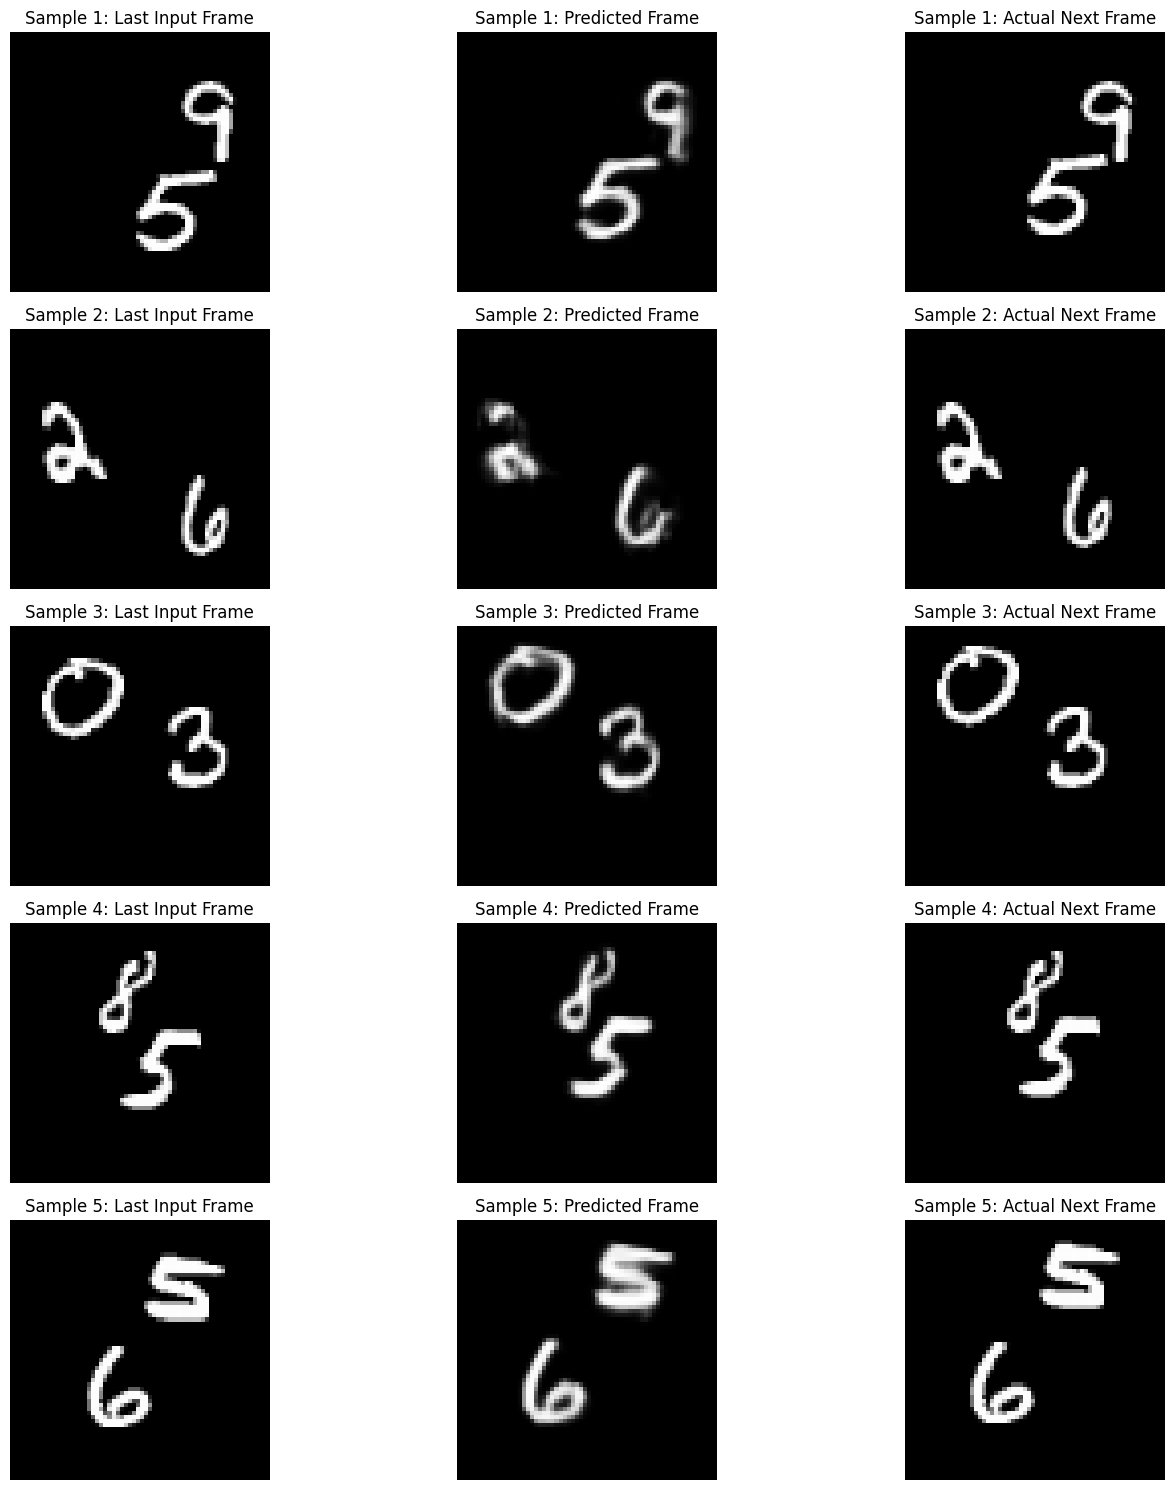

In [ ]:
def visualize_predictions(model, test_data, num_samples=5):
    test_loader = DataLoader(test_data, shuffle=True, batch_size=1, collate_fn=collate)
    
    model.eval()
    plt.figure(figsize=(15, 3*num_samples))
    
    with torch.no_grad():
        for i, (inputs, target) in enumerate(test_loader):
            if i >= num_samples:
                break
            
            # Debug visualization data
            print(f"\nVisualization sample {i+1}:")
            print(f"Input range: {inputs.min().item():.4f} to {inputs.max().item():.4f}")
            print(f"Target range: {target.min().item():.4f} to {target.max().item():.4f}")
            
            prediction = model(inputs)
            print(f"Prediction range: {prediction.min().item():.4f} to {prediction.max().item():.4f}")
            
            plt.subplot(num_samples, 3, i*3 + 1)
            plt.imshow(inputs[0, 0, -1].cpu().numpy(), cmap='gray')
            plt.title(f'Sample {i+1}: Last Input Frame')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(prediction[0, 0].cpu().numpy(), cmap='gray')
            plt.title(f'Sample {i+1}: Predicted Frame')
            plt.axis('off')
            
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(target[0, 0].cpu().numpy(), cmap='gray')
            plt.title(f'Sample {i+1}: Actual Next Frame')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()


# Visualize predictions
visualize_predictions(model, test_data)



In [27]:
# Save the trained model
torch.save(model.state_dict(), 'frame_predictor.pth')